In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
import KeyFunctions as me
import tensorflow as tf
RandState = 117

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, MaxPooling2D, LSTM, TimeDistributed, Reshape
from keras.backend import reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

n = 20

In [2]:
from sklearn.model_selection import train_test_split

#Import Full R6g Dataset
df, labels = me.ConstructCombinedDataset()
df = me.BaselineCorrection(me.BaselineCorrection(df))

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.9)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()

#Augment Data to 4000 Spectra
X_tnAu, y_tnAu = me.AugmentData(X_tn, y_tn, 4000, df.columns.to_numpy(), False)

In [3]:
#Set Training Parameters
verbose = 1
epochsvec = [5, 20, 50]
batch_sizevec = [10, 50, 100]
epochs = epochsvec[1]
batch_size = batch_sizevec[1]

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnAu)
X_tnS = scaler.transform(X_tnAu)
X_ttS = scaler.transform(X_tt)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))


#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnS.reshape(X_tnS.shape[0], X_tnS.shape[1], 1)
X_tt_p = X_ttS.reshape(X_ttS.shape[0], X_ttS.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)

display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

ytruth = tf.argmax(input = y_ttT, axis = 1).numpy()
ytruth = encoder.inverse_transform(ytruth)

TensorShape([4000, 472, 1])

TensorShape([4000, 8])

TensorShape([12, 472, 1])

TensorShape([12, 8])

In [5]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters = 64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 2,verbose = 0, restore_best_weights = True)

#Fit Model
history_sc = model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split = 0.1, callbacks = stopper)

#Evaluate Model
_, SCaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(SCaccuracy)

Epoch 1/20
72/72 [==============================] - 6s 52ms/step - loss: 0.7147 - accuracy: 0.7142 - val_loss: 0.4323 - val_accuracy: 0.8825
Epoch 2/20
72/72 [==============================] - 4s 55ms/step - loss: 0.2683 - accuracy: 0.9056 - val_loss: 0.1866 - val_accuracy: 0.9700
Epoch 3/20
72/72 [==============================] - 4s 52ms/step - loss: 0.0971 - accuracy: 0.9778 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 4/20
72/72 [==============================] - 3s 46ms/step - loss: 0.0275 - accuracy: 0.9964 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 5/20
72/72 [==============================] - 3s 48ms/step - loss: 0.0093 - accuracy: 0.9994 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 6/20
72/72 [==============================] - 4s 56ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 7/20
72/72 [==============================] - 4s 49ms/step - loss: 0.0460 - accuracy: 0.9944 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 8/20
1/

0.8333333134651184

In [6]:
#Make Prediction
SCypred = model.predict(X_ttT)
SCypred = tf.argmax(input = SCypred, axis = 1).numpy()
SCypred = encoder.inverse_transform(SCypred)


In [7]:
#Apply Fourier Transform to Training and Testing Data
X_tnf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_tnAu)
X_ttf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_tt)

#Combine Real and Imaginary Part of FT in form [real, imaginary]
X_tnf = np.append(X_tnf.real, X_tnf.imag, axis = 1)
X_ttf = np.append(X_ttf.real, X_ttf.imag, axis = 1)
X_tnf= X_tnf.astype('float32')
X_ttf= X_ttf.astype('float32')

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnf)
X_tnf = scaler.transform(X_tnf)
X_ttf = scaler.transform(X_ttf)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnf.reshape(X_tnf.shape[0], X_tnf.shape[1], 1)
X_tt_p = X_ttf.reshape(X_ttf.shape[0], X_ttf.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 944, 1])

TensorShape([4000, 8])

TensorShape([12, 944, 1])

TensorShape([12, 8])

In [8]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 2,verbose = 0, restore_best_weights = True)

#Fit Model
history_ft = model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.1, callbacks = stopper)

#Evaluate Model
_, FTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(FTaccuracy)

Epoch 1/20
72/72 [==============================] - 10s 117ms/step - loss: 1.0011 - accuracy: 0.6006 - val_loss: 0.7286 - val_accuracy: 0.6600
Epoch 2/20
72/72 [==============================] - 7s 104ms/step - loss: 0.6725 - accuracy: 0.7264 - val_loss: 0.5234 - val_accuracy: 0.8675
Epoch 3/20
72/72 [==============================] - 8s 113ms/step - loss: 0.3947 - accuracy: 0.8753 - val_loss: 0.2435 - val_accuracy: 0.9475
Epoch 4/20
72/72 [==============================] - 8s 106ms/step - loss: 0.1765 - accuracy: 0.9508 - val_loss: 0.1826 - val_accuracy: 0.9475
Epoch 5/20
72/72 [==============================] - 8s 114ms/step - loss: 0.0731 - accuracy: 0.9817 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 6/20
72/72 [==============================] - 8s 108ms/step - loss: 0.0237 - accuracy: 0.9981 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 7/20
72/72 [==============================] - 9s 118ms/step - loss: 0.0175 - accuracy: 0.9972 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch

0.75

In [9]:
#Make Prediction
FTypred = model.predict(X_ttT)
FTypred = tf.argmax(input = FTypred, axis = 1).numpy()
FTypred = encoder.inverse_transform(FTypred)

In [10]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht
X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tnAu)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)
X_tnh = X_tnh.astype('float32')
X_tth = X_tth.astype('float32')

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnh)
X_tnh = scaler.transform(X_tnh)
X_tth = scaler.transform(X_tth)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnh.reshape(X_tnh.shape[0], X_tnh.shape[1], 1)
X_tt_p = X_tth.reshape(X_tth.shape[0], X_tth.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 512, 1])

TensorShape([4000, 8])

TensorShape([12, 512, 1])

TensorShape([12, 8])

In [11]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = 'min',\
                                           patience = 2, verbose = 1, restore_best_weights = True)

#Fit Model
history_ht = model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.1, callbacks = stopper)

#Evaluate Model
_, HTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(HTaccuracy)

Epoch 1/20
72/72 [==============================] - 4s 51ms/step - loss: 1.0573 - accuracy: 0.5672 - val_loss: 0.7691 - val_accuracy: 0.6325
Epoch 2/20
72/72 [==============================] - 4s 49ms/step - loss: 0.7842 - accuracy: 0.6639 - val_loss: 0.7715 - val_accuracy: 0.6675
Epoch 3/20
72/72 [==============================] - 4s 59ms/step - loss: 0.7265 - accuracy: 0.6933 - val_loss: 0.6795 - val_accuracy: 0.6900
Epoch 4/20
72/72 [==============================] - 4s 58ms/step - loss: 0.6857 - accuracy: 0.7164 - val_loss: 0.6687 - val_accuracy: 0.7100
Epoch 5/20
72/72 [==============================] - 4s 50ms/step - loss: 0.5877 - accuracy: 0.7786 - val_loss: 0.5507 - val_accuracy: 0.7500
Epoch 6/20
72/72 [==============================] - 4s 51ms/step - loss: 0.4883 - accuracy: 0.8278 - val_loss: 0.3670 - val_accuracy: 0.9275
Epoch 7/20
72/72 [==============================] - 4s 58ms/step - loss: 0.3983 - accuracy: 0.8578 - val_loss: 0.2593 - val_accuracy: 0.9525
Epoch 8/20
72

0.9166666865348816

In [12]:
#Make Prediction
HTypred = model.predict(X_ttT)
HTypred = tf.argmax(input = HTypred, axis = 1).numpy()
HTypred = encoder.inverse_transform(HTypred)

In [13]:
from sklearn.metrics import confusion_matrix
display(SCypred)
CMSC = confusion_matrix(ytruth, SCypred, labels = labels)
CMFT = confusion_matrix(ytruth, FTypred, labels = labels)
CMHT = confusion_matrix(ytruth, HTypred, labels = labels)
display(SCaccuracy, FTaccuracy, HTaccuracy)

array(['10-16', '10-5', '10-14', '10-16', '10-9', '10-5', '10-7', '10-5',
       '10-5', '10-5', '10-7', '10-11'], dtype=object)

0.8333333134651184

0.75

0.9166666865348816

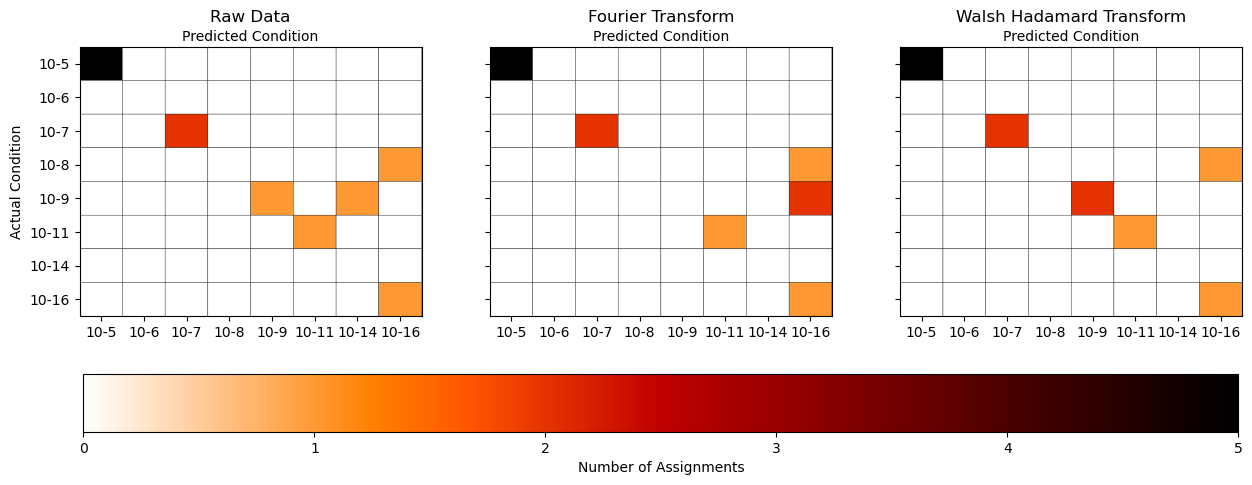

In [14]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMSC, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');

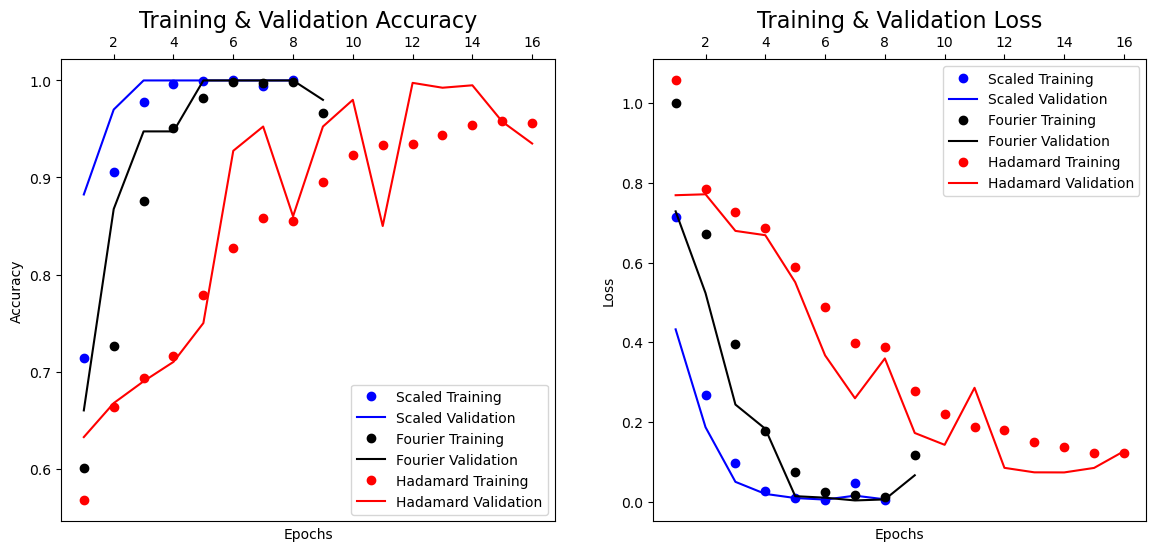

In [15]:
hist_dict = history_sc.history
train_loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
train_acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
epochs_vec = range(1, len(train_loss) + 1)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs_vec, train_acc, 'bo')
ax[0].plot(epochs_vec, val_acc, 'b')
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs_vec, train_loss, 'bo')
ax[1].plot(epochs_vec, val_loss, 'b')

hist_dict = history_ft.history
train_loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
train_acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
epochs_vec = range(1, len(train_loss) + 1)

#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs_vec, train_acc, 'ko')
ax[0].plot(epochs_vec, val_acc, 'k')

#
# Plot the loss vs Epochs
#
ax[1].plot(epochs_vec, train_loss, 'ko')
ax[1].plot(epochs_vec, val_loss, 'k')

hist_dict = history_ht.history
train_loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
train_acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
epochs_vec = range(1, len(train_loss) + 1)

#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs_vec, train_acc, 'ro')
ax[0].plot(epochs_vec, val_acc, 'r')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Scaled Training', 'Scaled Validation', 'Fourier Training', 'Fourier Validation', 'Hadamard Training', 'Hadamard Validation'])
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs_vec, train_loss, 'ro')
ax[1].plot(epochs_vec, val_loss, 'r')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Scaled Training', 'Scaled Validation', 'Fourier Training', 'Fourier Validation', 'Hadamard Training', 'Hadamard Validation']);

plt.savefig("Tables and Figures\SVG Files\CNN Learning Curve.svg", format = "svg", bbox_inches='tight')
plt.savefig("Tables and Figures\PNG Files\CNN Learning Curve.png", format = "png", bbox_inches='tight')